In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  "sans-serif" 
rcParams['font.sans-serif'] = "Liberation Sans"  # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [3]:
# Loading data
Rawdir="/data2/linzhuobin/Hap3D_Figures/figure_processing_data"
outdir=f"/data2/linzhuobin/Hap3D_Figures/pdf"
DF = pd.read_csv(f"{Rawdir}/Fig6/SDPR/chrX/DF_mapq5.txt",sep = "\t")

In [4]:
DF.loc[DF['ID'].str.contains("ENSG00000124313")]

,chrom,start,end,rid,fid,cid,pos,hp,HType,Pchrom,Pstart,Pend,ID,fpos,ppos,dis
878206,chrX,53324955,53329955,101005054,0,22,53327455,1,h1,chrX,53320350,53322350,ENSG00000124313.14,53327455.0,53321350.0,6105.0
878207,chrX,53324447,53329447,101005054,1,22,53326947,1,h1,chrX,53320350,53322350,ENSG00000124313.14,53326947.0,53321350.0,5597.0
878208,chrX,53343544,53348544,101005054,10,22,53346044,1,h1,chrX,53320350,53322350,ENSG00000124313.14,53346044.0,53321350.0,24694.0
878209,chrX,53322118,53327118,101005054,2,22,53324618,1,h1,chrX,53320350,53322350,ENSG00000124313.14,53324618.0,53321350.0,3268.0
878210,chrX,53331028,53336028,101005054,3,22,53333528,1,h1,chrX,53320350,53322350,ENSG00000124313.14,53333528.0,53321350.0,12178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881246,chrX,63634360,63639360,99877666,1,22,63636860,2,h2,chrX,53320350,53322350,ENSG00000124313.14,63636860.0,53321350.0,10315510.0
881247,chrX,53258528,53263528,99877666,3,22,53261028,2,h2,chrX,53320350,53322350,ENSG00000124313.14,53261028.0,53321350.0,60322.0
881248,chrX,53317873,53322873,99877666,4,22,53320373,2,h2,chrX,53320350,53322350,ENSG00000124313.14,53320373.0,53321350.0,977.0
881249,chrX,63762384,63767384,99877666,5,22,63764884,2,h2,chrX,53320350,53322350,ENSG00000124313.14,63764884.0,53321350.0,10443534.0


In [5]:
(53324955 + 53329955)//2

53327455

In [6]:
def GROUP_DICT(df):
    Dict = {}
    group = df.groupby("rid")
    for rid, df in group:
        Dict[rid] = df
    return Dict

def SORT(Dict):
    sort_dict = {}
    for readid, df in Dict.items():
        tmp_list = []
        tmp_list.append(min(df["fpos"]))
        tmp_list.append(df.iloc[0, 14])
        sort_dict[readid] = min(tmp_list)
    sort_list = sorted(sort_dict.items(), key = lambda kv:(kv[1], kv[0]))
    return sort_list

def line_dict(df):
    sort_list = sorted(df['pos_bin'].tolist())
    line_list = []
    plus = float(df.iloc[0,14]+600)
    negative = float(df.iloc[0,14]-600)
    left = float(df.iloc[0,14]-1000)
    right = float(df.iloc[0,14]+1000)
    read_count = len(df['rid'].unique())
    for i in sort_list:
        if i <= negative:
            i = left
            line_list.append(i)
        elif i <= plus:
            line_list.append(i)
        else:
            i = right
            line_list.append(i)
    tmp_dict = {}
    tmp_df = pd.DataFrame(line_list)
    tmp_group = tmp_df.groupby(0)
    for pos, count in tmp_group:
        tmp_dict[pos] = len(count) / read_count
    ref_list = list(range(int(df.iloc[0,14]-1000), int(df.iloc[0,14]+1000)+1, 1))
    for i in ref_list:
        if i in tmp_dict.keys():
            continue
        else:
            tmp_dict[i] = 0
    return tmp_dict

In [7]:
def location(i, region, Dict):
    loc = np.searchsorted(region, i)
    if (loc == 0):
        Dict[(region[0])] += 1
    else:
        Dict[(region[loc-1])] += 1
    return Dict

def divide_region(Dict, start, end, number = 5):
    region = np.linspace(start, end, number)
    
    for i in region:
        Dict[(i)] = 0
    
    gap = region[1] -  region[0]
    return Dict, region, gap

def fragment_count(df, Ppos, FLANK):
    """fragment count in distal or proximal region"""
    sort_list = sorted(df['fpos'].tolist())

    Dict1 = {}
    Dict2 = {}
    Dict3 = {}
    group = 8
    Dict1, region1, gap1 = divide_region(Dict1, 0, Ppos - FLANK, group)
    Dict2, region2, gap2 = divide_region(Dict2, Ppos - FLANK, Ppos + FLANK, group)
    Dict3, region3, gap3 = divide_region(Dict3, Ppos + FLANK, max(sort_list), group)
    
    n = 0
    for i in sort_list:
        if i < Ppos - FLANK:
            Dict1 = location(i, region1, Dict1)
        elif (i >= Ppos - FLANK) & (i < Ppos + FLANK):
            Dict2 = location(i, region2, Dict2)
        elif i >= Ppos + FLANK:
            Dict3 = location(i, region3, Dict3)
        n += 1
    return Dict1, Dict2, Dict3, gap1, gap2, gap3

In [8]:
# def single_DLR(df):
#     """Calcualte SDPR"""
#     single_dict = {}
#     for rid,df in df.groupby("rid"):
#         single_dict[rid] = df
#     mean_dict = {}
#     for rid, gdf in single_dict.items():
#         dis_count = len(gdf.loc[gdf.dis > 1500000])
#         loc_count = len(gdf.loc[gdf.dis <= 1500000])
#         if loc_count == 0:
#             mean_dict[rid] = 0
#         else:
#             mean_dict[rid] =  dis_count / loc_count
#     return mean_dict

In [9]:
SELECT_PRO = "ENSG00000102317.17"
Ppos = 48574449

example_df = DF.loc[DF["ID"].str.contains(f"{SELECT_PRO}")]
example_df_h1 = example_df.loc[example_df.HType == "h1"]
example_df_h2 = example_df.loc[example_df.HType == "h2"]

example_df_h1_dict = GROUP_DICT(example_df_h1)
example_df_h2_dict = GROUP_DICT(example_df_h2)

sort_list_h1 = SORT(example_df_h1_dict)
sort_list_h2 = SORT(example_df_h2_dict)

In [10]:
example_df_h1

,chrom,start,end,rid,fid,cid,pos,hp,HType,Pchrom,Pstart,Pend,ID,fpos,ppos,dis
719755,chrX,53960667,53965667,100487004,1,22,53963167,1,h1,chrX,48573449,48575449,ENSG00000102317.17,53963167.0,48574449.0,5388718.0
719756,chrX,53959427,53964427,100487004,2,22,53961927,1,h1,chrX,48573449,48575449,ENSG00000102317.17,53961927.0,48574449.0,5387478.0
719757,chrX,48570825,48575825,100487004,3,22,48573325,1,h1,chrX,48573449,48575449,ENSG00000102317.17,48573325.0,48574449.0,1124.0
719758,chrX,48549753,48554753,100487004,4,22,48552253,1,h1,chrX,48573449,48575449,ENSG00000102317.17,48552253.0,48574449.0,22196.0
719759,chrX,54552820,54557820,100487004,5,22,54555320,1,h1,chrX,48573449,48575449,ENSG00000102317.17,54555320.0,48574449.0,5980871.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724007,chrX,40297985,40302985,98954466,4,22,40300485,1,h1,chrX,48573449,48575449,ENSG00000102317.17,40300485.0,48574449.0,8273964.0
724008,chrX,40301359,40306359,98954466,5,22,40303859,1,h1,chrX,48573449,48575449,ENSG00000102317.17,40303859.0,48574449.0,8270590.0
724009,chrX,40380612,40385612,98954466,6,22,40383112,1,h1,chrX,48573449,48575449,ENSG00000102317.17,40383112.0,48574449.0,8191337.0
724010,chrX,40372460,40377460,98954466,7,22,40374960,1,h1,chrX,48573449,48575449,ENSG00000102317.17,40374960.0,48574449.0,8199489.0


In [11]:
def SDPRHighOrderPlot(hap_df, SELECT_PRO, Hap="h1", FLANK = 1500000):
    '''
        high order fragment line plot for haplotype SDPR
    '''
    example_df = DF.loc[DF["ID"].str.contains(f"{SELECT_PRO}")]
    example_df = example_df.loc[example_df.HType ==  Hap]
    example_df_dict = GROUP_DICT(example_df)
    sort_list = SORT(example_df_dict)
    
    hapcolor = {"h1":"red", "h2":"blue"}
    # plot
    plt.subplots_adjust(hspace=0.5)
    MAX = []
    fig, axes = plt.subplots(nrows=1,ncols=3,
                             sharey = True, figsize = (5, 2)) 
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    # fragments
    for i in sort_list:
        row1 = example_df.loc[example_df.rid == i[0]]
        for index,row in row1.iterrows():
            axes[1].plot(row["ppos"], str(row["rid"]), 's', color = hapcolor[Hap], linewidth=0.8, markersize=0.5)
            if row['dis'] < FLANK:
                color = "g"
                axes[1].plot(row["fpos"], str(row["rid"]), 's', color = color, linewidth=0.8, markersize=0.5)
            else:
                if row["fpos"]<row["ppos"]:
                    color = "k"
                    axes[0].plot(row["fpos"], str(row["rid"]), 's', color = color, linewidth=0.8, markersize=0.5)
                if row["fpos"]>row["ppos"]:
                    color = "k"
                    axes[2].plot(row["fpos"], str(row["rid"]), 's', color = color, linewidth=0.8, markersize=0.5)
    # contact lines            
    for rid, gdf in example_df.groupby("rid"):
        a = gdf["fpos"].tolist()
        a.append(gdf.iloc[0, 14])
        tmp1 = min(a)
        tmp2 = max(a)
        if (tmp1 < row["ppos"] - FLANK) & (tmp2 > row["ppos"] + FLANK):
            axes[0].plot([tmp1,row["ppos"] -FLANK], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
            axes[1].plot([row["ppos"] - FLANK,row["ppos"] + FLANK], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
            axes[2].plot([row["ppos"] + FLANK,tmp2], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
        elif (tmp1 < row["ppos"] - FLANK) & (tmp2 <= row["ppos"] + FLANK) & (tmp2 >= row["ppos"] - 200):
            axes[0].plot([tmp1,row["ppos"] - FLANK], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
            axes[1].plot([row["ppos"] - FLANK,tmp2], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
        elif tmp2 < row["ppos"] - FLANK:
            axes[0].plot([tmp1,tmp2], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
        elif ((tmp1 >= row["ppos"] - FLANK) & (tmp1 <= row["ppos"] + FLANK) &
              (tmp2 >= row["ppos"] - FLANK) & (tmp2 <= row["ppos"] + FLANK)):
            axes[1].plot([tmp1,tmp2], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
        elif ((tmp1 >= row["ppos"] - FLANK) & (tmp1 <= row["ppos"] + FLANK) & (tmp2 > row["ppos"] + 200)):
            MAX.append(tmp2)
            axes[1].plot([tmp1,row["ppos"] + FLANK], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
            axes[2].plot([row["ppos"] + FLANK,tmp2], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)
        elif ((tmp1 > row["ppos"] + FLANK) & (tmp2 > row["ppos"] + FLANK)):
            axes[2].plot([tmp1,tmp2], 
                         [str(gdf["rid"].tolist()[0]), str(gdf["rid"].tolist()[0])], '-',color = "grey", linewidth=0.1)

    plt.tick_params(labelleft = False,left = False)
    for i in range(0,3):
        axes[i].tick_params(labelleft = False,
                                  left = False)
    axes[0].tick_params(labelleft=False, left=False,
                       bottom = False, labelbottom = False)
    axes[0].set_xlim(0, row["ppos"] - FLANK)
    axes[1].set_xlim(row["ppos"] - FLANK,
                      row["ppos"] + FLANK)
    axes[2].set_xlim(row["ppos"] + FLANK, max(MAX))

    axes[0].set_xticks([0, row["ppos"] - FLANK],)
    axes[1].set_xticks([row["ppos"] - FLANK, row["ppos"],
                      row["ppos"] + FLANK],)
    axes[2].set_xticks([row["ppos"] + FLANK],)
    plt.savefig(f"{outdir}/{Hap}_high_order_contact_{SELECT_PRO}.pdf")
    return(example_df)

<Figure size 640x480 with 0 Axes>

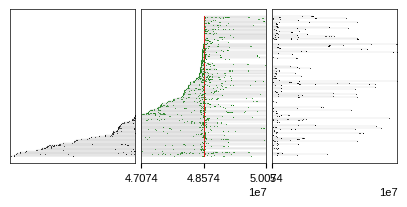

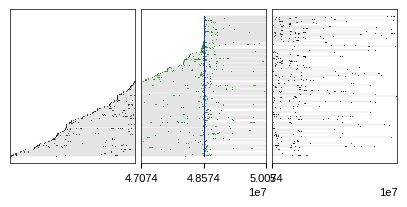

In [89]:
SELECT_PRO = "ENSG00000102317.17"
Ppos = 48574449
FLANK = 1500000
example_df_h1 = SDPRHighOrderPlot(DF, SELECT_PRO, "h1")
example_df_h2 = SDPRHighOrderPlot(DF, SELECT_PRO, "h2")

<Figure size 640x480 with 0 Axes>

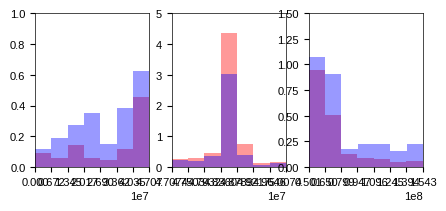

In [90]:
# contact frequence histogram 
Dict1_h1, Dict2_h1, Dict3_h1, gap1_h1, gap2_h1, gap3_h1 = fragment_count(example_df_h1, Ppos, FLANK )
Dict1_h2, Dict2_h2, Dict3_h2, gap1_h2, gap2_h2, gap3_h2 = fragment_count(example_df_h2, Ppos, FLANK )
h1_dict_list = [Dict1_h1, Dict2_h1, Dict3_h1]
h2_dict_list = [Dict1_h2, Dict2_h2, Dict3_h2]
gap_h1_list = [gap1_h1, gap2_h1, gap3_h1]
gap_h2_list = [gap1_h2, gap2_h2, gap3_h2]
plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=1,ncols=3, figsize = (5, 2)) 

i = 0
for h1_dict in h1_dict_list:

    for pos, value in h1_dict.items():
        h1_dict[pos] = value / len(example_df_h1['rid'].unique())
    
    h1_x = h1_dict.keys()
    h1_y = h1_dict.values()
    axes[i].bar(h1_x, h1_y, align = "edge", width = gap_h1_list[i], color = "red", alpha=0.4)
    axes[i].set_xticks(list(h1_x) ,)
    axes[i].set_xlim(list(h1_x)[0], list(h1_x)[-1])
    i += 1

i = 0
for h2_dict in h2_dict_list:    
    for pos, value in h2_dict.items():
        h2_dict[pos] = value / len(example_df_h2['rid'].unique()) 
        
    h2_x = h2_dict.keys()
    h2_y = h2_dict.values()
    axes[i].bar(h2_x, h2_y, align = "edge", width = gap_h2_list[i], color = "blue", alpha=0.4)
    i += 1

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 5)
axes[2].set_ylim(0, 1.5)

plt.savefig(f"{outdir}/h1_h2_SDPR_high_order_frequency_bar_{SELECT_PRO}.pdf")

<Figure size 640x480 with 0 Axes>

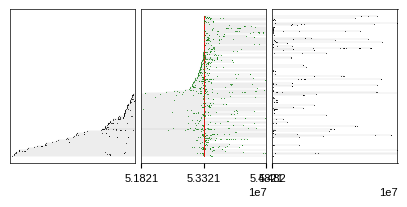

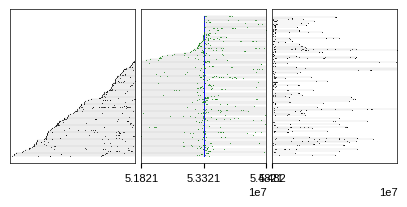

In [61]:
# CTPS2
SELECT_PRO = "ENSG00000124313.14"
Ppos = 53327455
FLANK = 1500000
example_df_h1 = SDPRHighOrderPlot(DF, SELECT_PRO, "h1")
example_df_h2 = SDPRHighOrderPlot(DF, SELECT_PRO, "h2")

<Figure size 640x480 with 0 Axes>

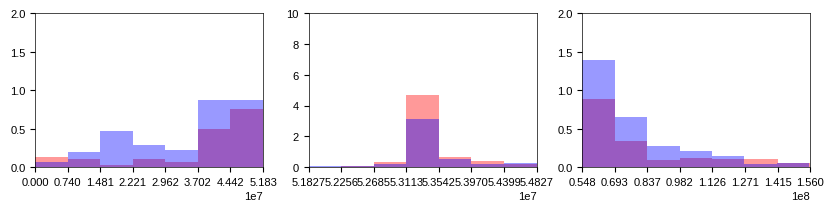

In [62]:
# contact frequence histogram 
Dict1_h1, Dict2_h1, Dict3_h1, gap1_h1, gap2_h1, gap3_h1 = fragment_count(example_df_h1, Ppos, FLANK )
Dict1_h2, Dict2_h2, Dict3_h2, gap1_h2, gap2_h2, gap3_h2 = fragment_count(example_df_h2, Ppos, FLANK )
h1_dict_list = [Dict1_h1, Dict2_h1, Dict3_h1]
h2_dict_list = [Dict1_h2, Dict2_h2, Dict3_h2]
gap_h1_list = [gap1_h1, gap2_h1, gap3_h1]
gap_h2_list = [gap1_h2, gap2_h2, gap3_h2]
plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=1,ncols=3, figsize = (10, 2)) 

i = 0
for h1_dict in h1_dict_list:
    for pos, value in h1_dict.items():
        h1_dict[pos] = value / len(example_df_h1['rid'].unique())
    
    h1_x = h1_dict.keys()
    h1_y = h1_dict.values()
    axes[i].bar(h1_x, h1_y, align = "edge", width = gap_h1_list[i], color = "red", alpha=0.4)
    axes[i].set_xticks(list(h1_x) ,)
    axes[i].set_xlim(list(h1_x)[0], list(h1_x)[-1])
    i += 1

i = 0
for h2_dict in h2_dict_list:    
    for pos, value in h2_dict.items():
        h2_dict[pos] = value / len(example_df_h2['rid'].unique()) 
        
    h2_x = h2_dict.keys()
    h2_y = h2_dict.values()
    axes[i].bar(h2_x, h2_y, align = "edge", width = gap_h2_list[i], color = "blue", alpha=0.4)
    i += 1

axes[0].set_ylim(0, 2)
axes[1].set_ylim(0, 10)
axes[2].set_ylim(0, 2)

plt.savefig(f"{outdir}/h1_h2_SDPR_high_order_frequency_bar_{SELECT_PRO}.pdf")